<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *
from lib.dynapse2_raster import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "network_heatmaps")

In [2]:
[board,profile_path,number_of_chips]=obtain_board()

<font size=8> SWEEP

In [181]:
neuron_config=neuron_configs_bio.config()
#remove SST connections to focus in th eEI balance structure
neuron_config['Input_SST']=0
neuron_config['PC_SST']=0
neuron_config['PC_Adaptation']=True


In [10]:
def run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name, save_name, data_type_path, neuron_config):

    data=os.path.join(data_type_path, f"{sweep_name}.npy")

    if os.path.exists(data):
        simulation_data = np.load(data, allow_pickle=True).item()
    else:
        simulation_data = {
            "cv_values_pc": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "cv_values_pv": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "synchrony_values_pc": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "synchrony_values_pv": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "mean_pc_rates": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            config_var_name_1: sweep_range_1,
            config_var_name_2: sweep_range_2
        }
    for value_1 in simulation_data[config_var_name_1]:
        neuron_config[config_var_name_1] = value_1
        for value_2 in simulation_data[config_var_name_2]:
            if contains_nan(simulation_data,config_var_name_1,config_var_name_2,value_1, value_2):
                neuron_config[config_var_name_2] = value_2
                try:
                    [output_events, test_config] = run_simulation(neuron_config)

                    cv_temp, synchrony_temp = run_dynamic_anal(output_events, test_config)

                    rates = spike_count(output_events=output_events)
                    PC_rates, _, _ = pop_rates(rates, test_config)

                    index = len(simulation_data[config_var_name_2]) * list(simulation_data[config_var_name_1]).index(value_1) + list(simulation_data[config_var_name_2]).index(value_2)
                    simulation_data["cv_values_pc"][index] = cv_temp[0]
                    simulation_data["cv_values_pv"][index] = cv_temp[1]
                    simulation_data["synchrony_values_pc"][index] = synchrony_temp[0]
                    simulation_data["synchrony_values_pv"][index] = synchrony_temp[1]
                    simulation_data["mean_pc_rates"][index] = np.mean(PC_rates)
                except timeout_decorator.TimeoutError:
                    print(f"Simulation timed out for {config_var_name_1} {value_1} and {config_var_name_2} {value_2}")
                    index = len(simulation_data[config_var_name_2]) * list(simulation_data[config_var_name_1]).index(value_1) + list(simulation_data[config_var_name_2]).index(value_2)
                    simulation_data["cv_values_pc"][index] = np.nan
                    simulation_data["cv_values_pv"][index] = np.nan
                    simulation_data["synchrony_values_pc"][index] = np.nan
                    simulation_data["synchrony_values_pv"][index] = np.nan
                    simulation_data["mean_pc_rates"][index] = np.nan

    if not os.path.exists(data_type_path):
        os.makedirs(data_type_path)
    np.save(os.path.join(data_type_path, f"{save_name}.npy"), simulation_data)


@timeout_decorator.timeout(40)# Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

<font size=6> Poisson PC PC


In [ ]:

neuron_config['input_type']='Poisson'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_poisson'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

<font size=6> Poisson PC PV


In [ ]:

neuron_config['input_type']='Poisson'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PV'
sweep_name='EI_sweep_PC_PV_poisson'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

<font size=6> Regular PC PC


In [ ]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

In [ ]:
run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

<font size=6> Regular PC PC


In [ ]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

<font size=8> Heatmaps Plotting

In [8]:
FONT_SIZE = 12
plt.rcParams['font.size'] = FONT_SIZE
import matplotlib.image

def plot_heatmap(data_matrix, ax, cmap, xlabel, ylabel, title, cbar_label,
                 x_ticks, x_ticklabels, y_ticks, y_ticklabels):
    """
    Helper function to plot a heatmap.
    """
    sns.heatmap(data_matrix[::-1], ax=ax, cmap=cmap, cbar_kws={'label': cbar_label})  # <-- Reverse the rows here
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels[::-1])  # <-- Reverse the yticklabels here
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def visualize_single_heatmap(data, freq_range=None, title='insert_title',x_axis_label='connection_ratios'):
    """
    Load and visualize simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    # Determine the indices of the frequencies in the range
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Extract the data and select only the desired range
    cv_values_pc = np.array(data['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices]
    synchrony_values_pc = np.array(data['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices]
    mean_pc_rates = np.array(data['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices]
    input_frequencies = input_frequencies[freq_indices]

    connection_ratios = [round(x, 1) for x in data['connection_ratios']]
    
    y_ticks = np.arange(0, len(input_frequencies), max(1, len(input_frequencies) // 5))
    y_ticklabels = [input_frequencies[i] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)
    plot_heatmap(cv_values_pc, ax[0], 'viridis', x_axis_label, 'Input Frequencies', 'CV Values PC', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc, ax[1], 'viridis', x_axis_label, 'Input Frequencies', 'Synchrony Values PC', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates, ax[2], 'viridis', x_axis_label, 'Input Frequencies', 'Mean Firing Rates PC', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    plt.tight_layout()
    plt.show()

    return fig,ax




In [ ]:
def visualize_combined_simulation_data(data1, data2, freq_range=None, title='insert_title', x_axis_label1='connection_ratios1', x_axis_label2='connection_ratios2'):
    """
    Load and visualize combined simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Add these diagnostic print statements:
    print(f"Frequency Indices: {freq_indices}")
    print(f"Length of Frequency Indices: {len(freq_indices)}")

    # For Data1
    cv_values_pc1 = np.array(data1['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc1 = np.array(data1['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates1 = np.array(data1['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    # For Data2
    cv_values_pc2 = np.array(data2['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc2 = np.array(data2['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates2 = np.array(data2['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    connection_ratios = [round(x, 1) for x in data1['connection_ratios']]
    
    y_ticks = np.arange(0, len(freq_indices), max(1, len(freq_indices) // 5))
    y_ticklabels = [input_frequencies[freq_indices[i]] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting in a 2x3 grid
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    """
    Load and visualize combined simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Add these diagnostic print statements:
    print(f"Frequency Indices: {freq_indices}")
    print(f"Length of Frequency Indices: {len(freq_indices)}")

    # For Data1
    cv_values_pc1 = np.array(data1['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc1 = np.array(data1['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates1 = np.array(data1['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    # For Data2
    cv_values_pc2 = np.array(data2['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc2 = np.array(data2['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates2 = np.array(data2['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    connection_ratios = [round(x, 1) for x in data1['connection_ratios']]
    
    y_ticks = np.arange(0, len(freq_indices), max(1, len(freq_indices) // 5))
    y_ticklabels = [input_frequencies[freq_indices[i]] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting in a 2x3 grid
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # Data 1
    plot_heatmap(cv_values_pc1, ax[0,0], 'viridis', x_axis_label1, 'Input Frequencies', 'CV Values PC1', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc1, ax[0,1], 'viridis', x_axis_label1, 'Input Frequencies', 'Synchrony Values PC1', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates1, ax[0,2], 'viridis', x_axis_label1, 'Input Frequencies', 'Mean Firing Rates PC1', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    # Data 2
    plot_heatmap(cv_values_pc2, ax[1,0], 'viridis', x_axis_label2, 'Input Frequencies', 'CV Values PC2', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc2, ax[1,1], 'viridis', x_axis_label2, 'Input Frequencies', 'Synchrony Values PC2', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates2, ax[1,2], 'viridis', x_axis_label2, 'Input Frequencies', 'Mean Firing Rates PC2', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

    return fig, ax



<font size=6> Regular Input

In [2]:
data_path = os.path.join(data_type_path, "EI_sweep_regular.npy")
data_1 = np.load(data_path, allow_pickle=True).item()

In [3]:
data_path = os.path.join(data_type_path, "EE_sweep_regular.npy")
data_2 = np.load(data_path, allow_pickle=True).item()


In [185]:
print(data_1.keys())
print(data_1['cv_values_pc'][24])
print(data_1['synchrony_values_pc'][24])
print(data_1['mean_pc_rates'][24])
print(data_1['input_frequencies'][12])
print(data_1['connection_ratios'][5])

dict_keys(['cv_values_pc', 'cv_values_pv', 'synchrony_values_pc', 'synchrony_values_pv', 'mean_pc_rates', 'input_frequencies', 'connection_ratios'])
0.07486100734754297
0.3685843255163035
32.89
13
0.5


Frequency Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Length of Frequency Indices: 16


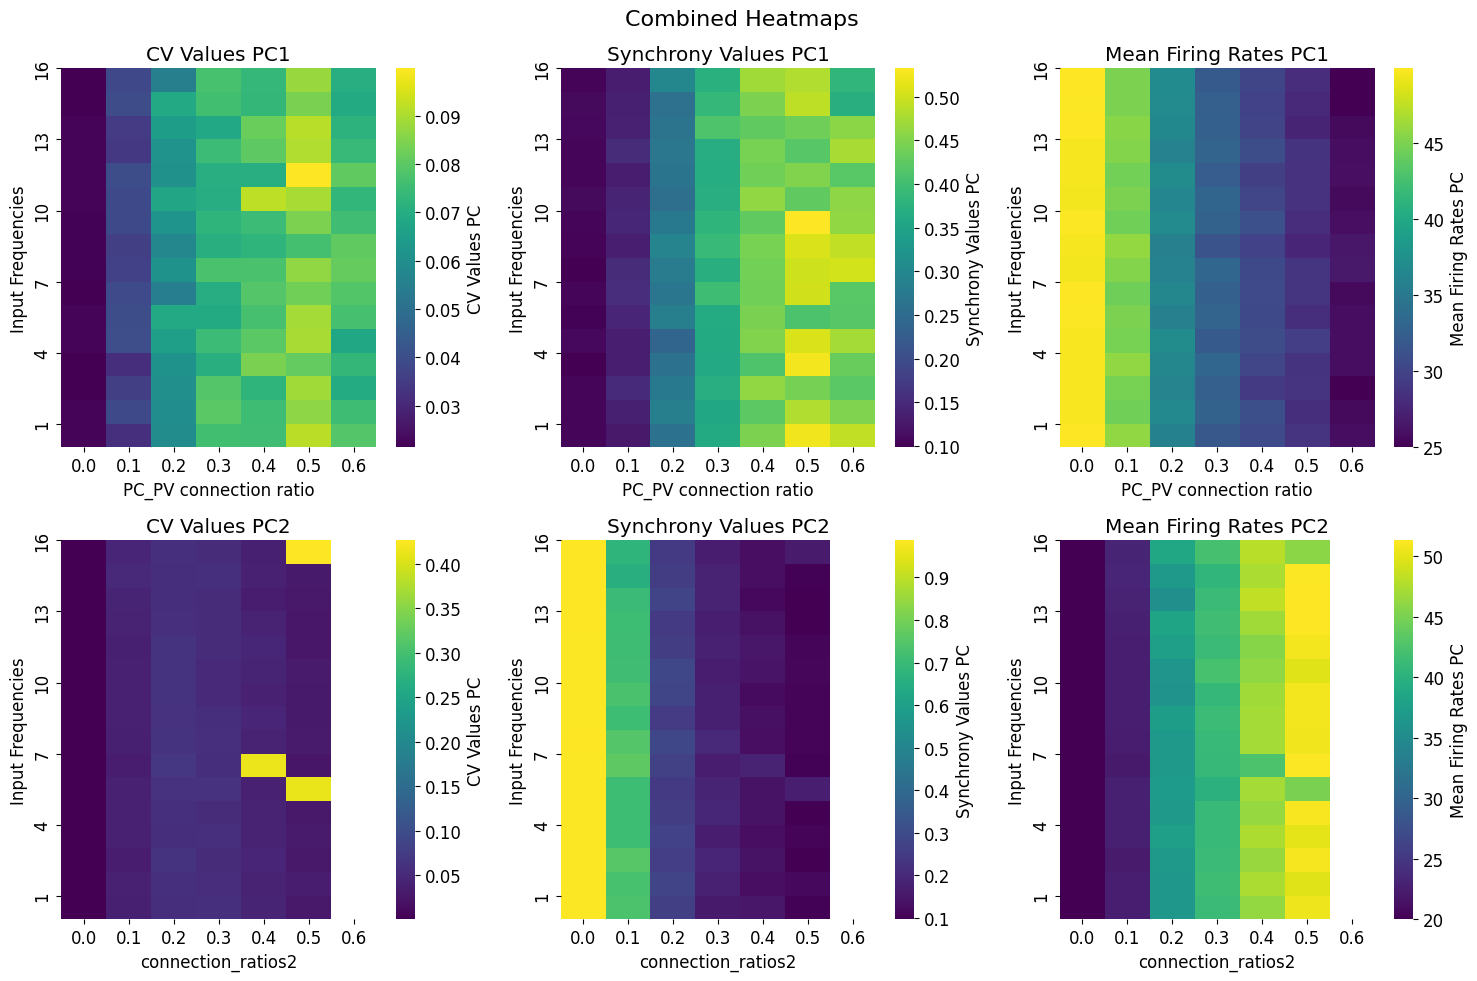

In [186]:
fig, ax = visualize_combined_simulation_data(data_1, data_2, freq_range=(0, 16), title="Combined Heatmaps", x_axis_label1='PC_PV connection ratio')


In [4]:
data_path = os.path.join(data_type_path, "EE_sweep_poisson.npy")
data_3 = np.load(data_path, allow_pickle=True).item()



In [5]:
data_path = os.path.join(data_type_path, "EI_sweep_poisson.npy")
data_4 = np.load(data_path, allow_pickle=True).item()


Frequency Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Length of Frequency Indices: 20


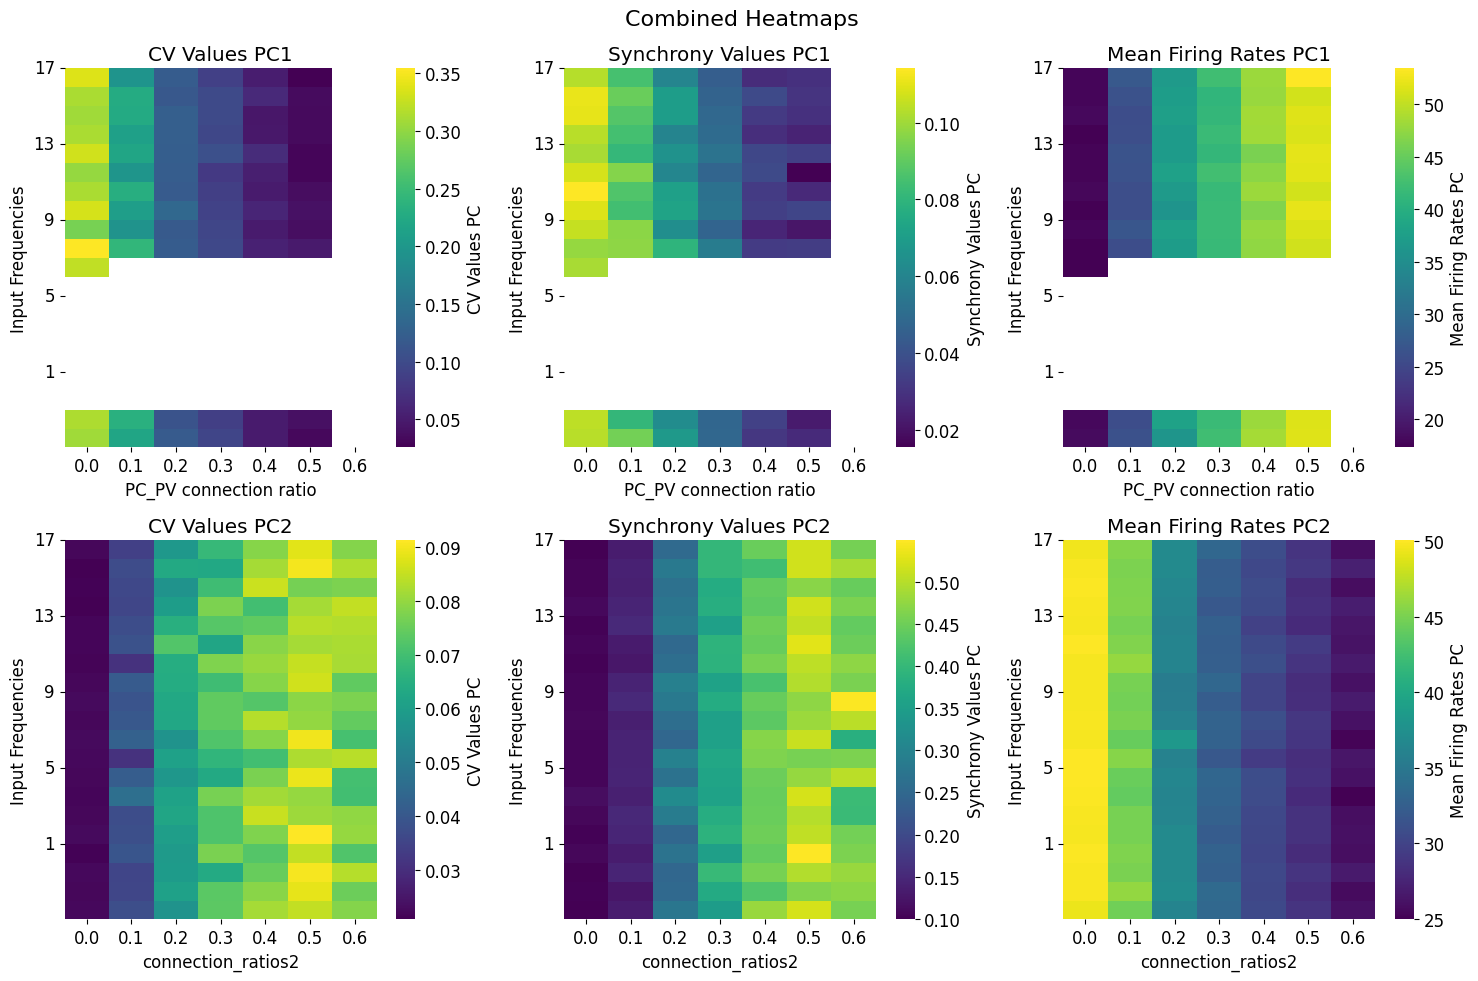

In [174]:
fig, ax = visualize_combined_simulation_data(data_1, data_2, freq_range=(0, 20), title="Combined Heatmaps", x_axis_label1='PC_PV connection ratio')


In [9]:
def visualize_combined_simulation_data(data1, data2, data3, data4, freq_range=None, title='insert_title', x_axis_labels=None):
    """
    Load and visualize combined simulation data for four data structures.
    """
    input_frequencies = np.arange(1, 31, 1)
    
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Diagnostic print statements
    print(f"Frequency Indices: {freq_indices}")
    print(f"Length of Frequency Indices: {len(freq_indices)}")

    # Data processing for all data structures
    datasets = [data1, data2, data3, data4]
    cv_values_pc = []
    synchrony_values_pc = []
    mean_pc_rates = []

    for data in datasets:
        cv_values_pc.append(np.array(data['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]])
        synchrony_values_pc.append(np.array(data['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]])
        mean_pc_rates.append(np.array(data['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]])

    connection_ratios = [round(x, 1) for x in data1['connection_ratios']]
    y_ticks = np.arange(0, len(freq_indices), max(1, len(freq_indices) // 5))
    y_ticklabels = [input_frequencies[freq_indices[i]] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting in a 4x3 grid
    fig, ax = plt.subplots(4, 3, figsize=(15, 20))

      
    # Plotting in a 4x3 grid
    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    subplot_labels = list(string.ascii_uppercase)[:12]  # Generate labels A to L
    
    for i, label in enumerate(subplot_labels):
        row = i // 3
        col = i % 3
        x_label = x_axis_labels[row] if x_axis_labels else f'connection_ratios{row + 1}'
        
        # Here we use // to get the floor division, ensuring we select the correct dataset
        dataset_index = row
        plot_heatmap(cv_values_pc[dataset_index], ax[row, col], 'viridis', x_label, 'Input Frequencies', f'CV Values PC{dataset_index + 1}', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
        
        # Add panel label
        ax[row, col].text(-0.1, 1.1, label, transform=ax[row, col].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    

    for i in range(4):
        # Determine x-axis label
        x_label = x_axis_labels[i] if x_axis_labels else f'connection_ratios{i + 1}'
        
        # Plot heatmaps for each data
        plot_heatmap(cv_values_pc[i], ax[i, 0], 'viridis', x_label, 'Input Frequencies', f'CV Values PC{i + 1}', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
        plot_heatmap(synchrony_values_pc[i], ax[i, 1], 'viridis', x_label, 'Input Frequencies', f'Synchrony Values PC{i + 1}', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
        plot_heatmap(mean_pc_rates[i], ax[i, 2], 'viridis', x_label, 'Input Frequencies', f'Mean Firing Rates PC{i + 1}', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)

    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

    return fig, ax


Frequency Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Length of Frequency Indices: 30


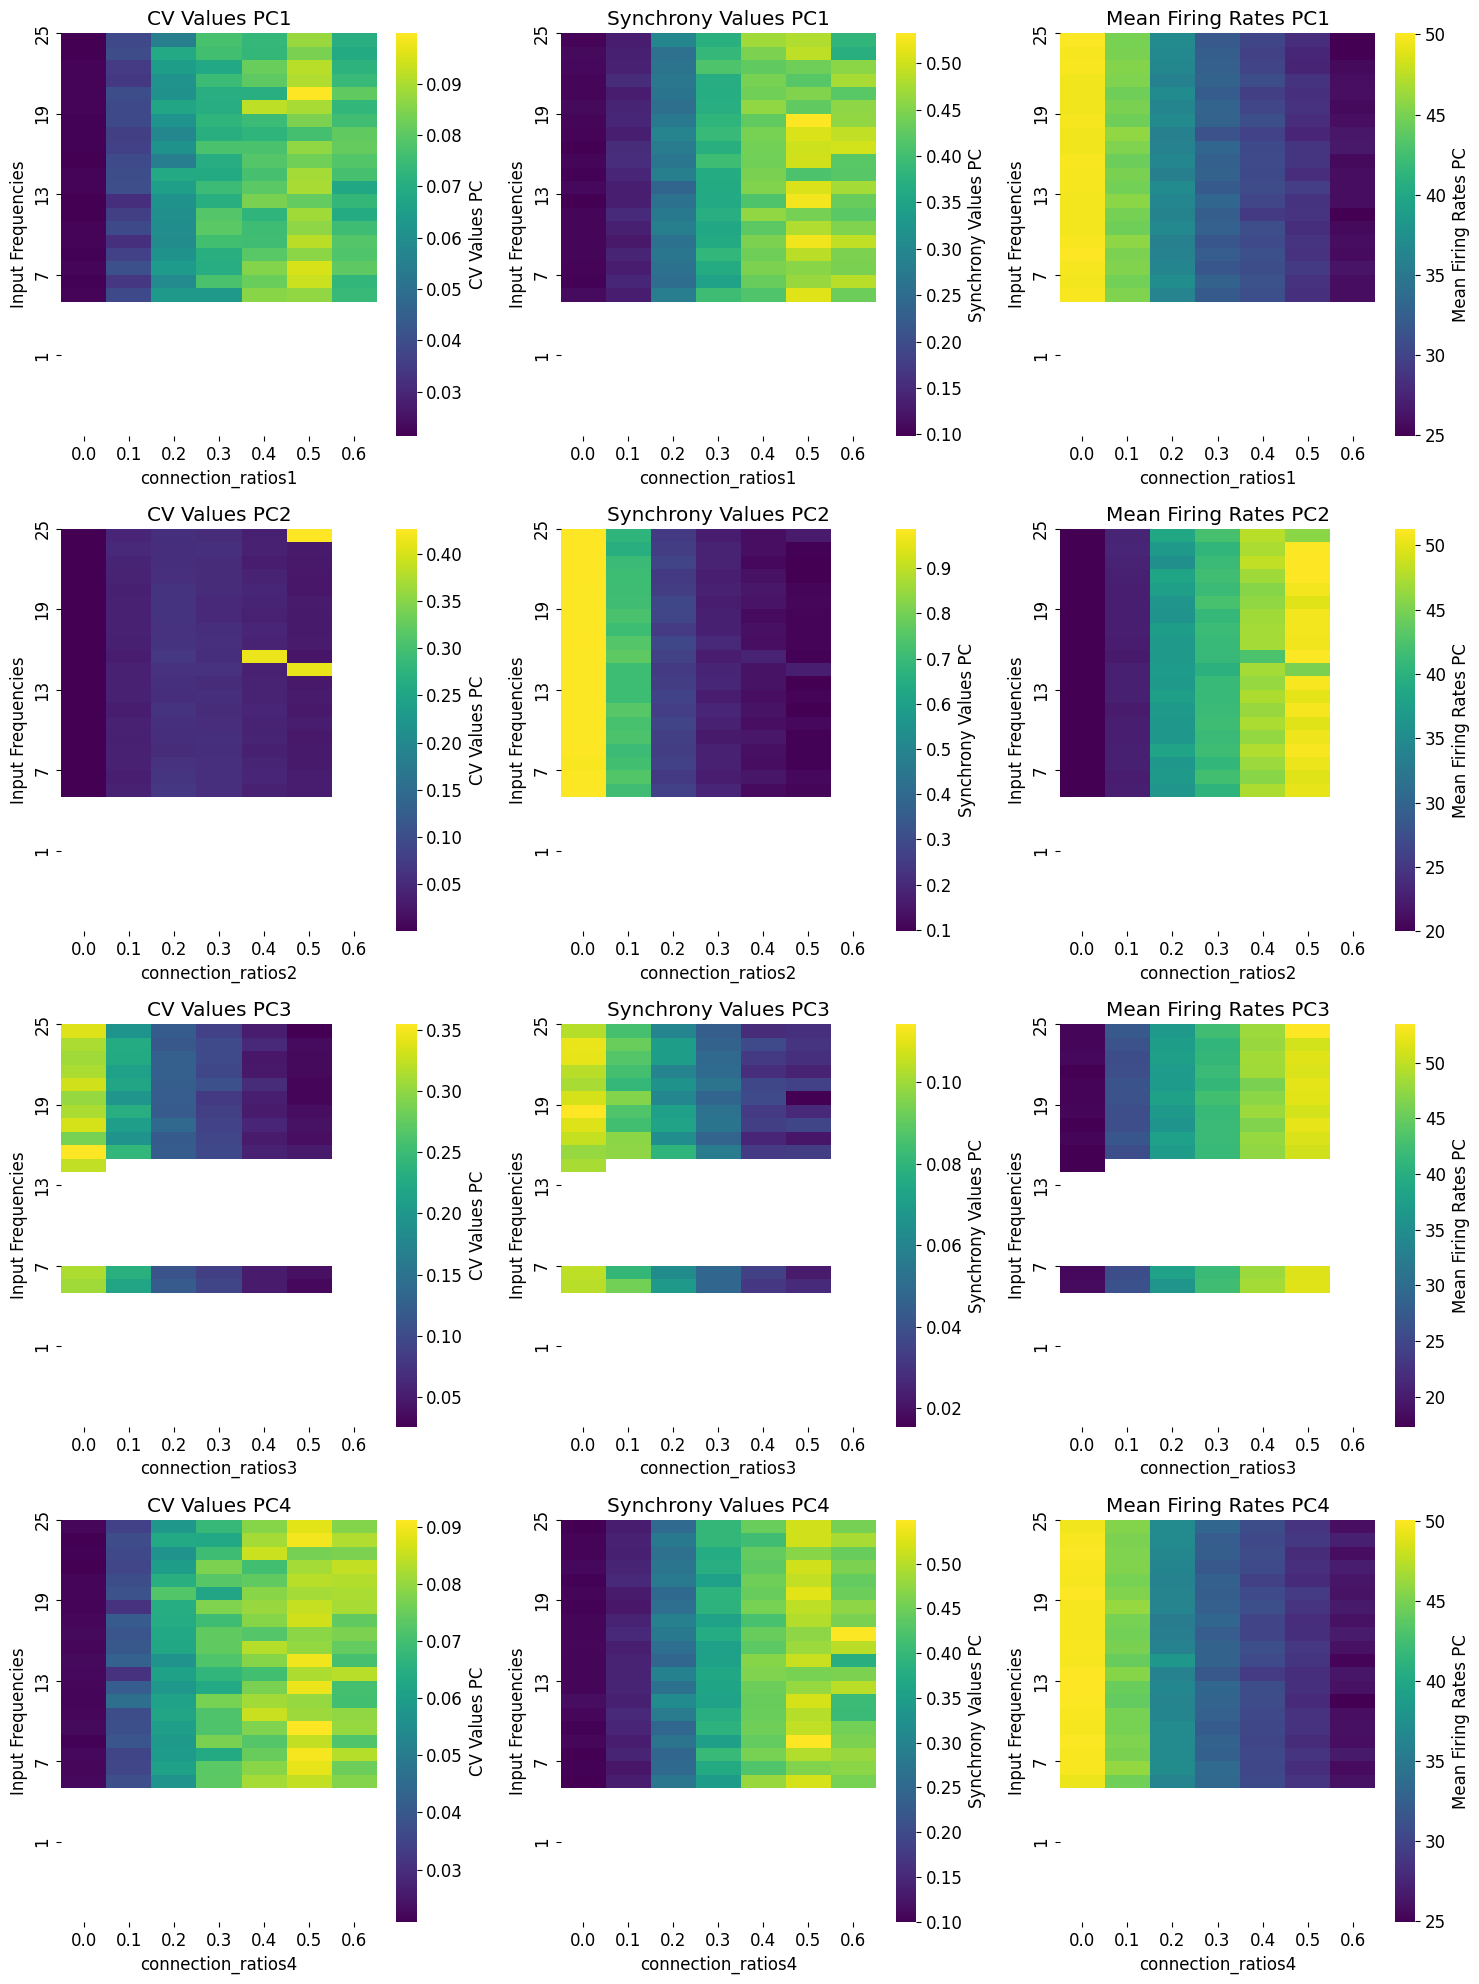

(<Figure size 1500x2000 with 24 Axes>,
 array([[<Axes: title={'center': 'CV Values PC1'}, xlabel='connection_ratios1', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Synchrony Values PC1'}, xlabel='connection_ratios1', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Mean Firing Rates PC1'}, xlabel='connection_ratios1', ylabel='Input Frequencies'>],
        [<Axes: title={'center': 'CV Values PC2'}, xlabel='connection_ratios2', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Synchrony Values PC2'}, xlabel='connection_ratios2', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Mean Firing Rates PC2'}, xlabel='connection_ratios2', ylabel='Input Frequencies'>],
        [<Axes: title={'center': 'CV Values PC3'}, xlabel='connection_ratios3', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Synchrony Values PC3'}, xlabel='connection_ratios3', ylabel='Input Frequencies'>,
         <Axes: title={'center': 'Mean Firing Rate

In [10]:
x_lavels = ['PC_PV connection ratio', 'PC_PC connection ratio', 'PC_PV connection ratio', 'PC_PC connection ratio']
visualize_combined_simulation_data(data_1, data_2, data_3, data_4, freq_range=None, title='insert_title', x_axis_labels=None)